In [2]:
import cv2
import math
import numpy as np
import os
import matplotlib.pyplot as plt
import polarTransform
from PIL import Image, ImageDraw
from tqdm import tqdm
import glob
from PIL import Image

In [23]:
# Get the paths of every file given a parent directory
def get_all_files(path):
    vect = []
    for path, subdirs, files in os.walk(path):
        for name in files:
            if (name == '.DS_Store') | (name=='Readme.txt'):
                pass
            else:
                vect.append(os.path.join(path, name))
        vect = sorted(vect)
    return vect

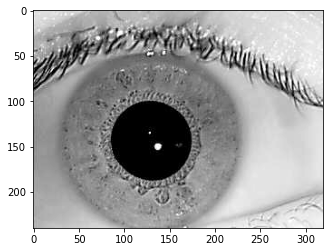

In [24]:
# Loading the image
images = get_all_files('../dataset/images/')
img = cv2.imread(images[0], cv2.IMREAD_GRAYSCALE)
img = np.float32(img)
plt.imshow(img, cmap='gray')
im = Image.fromarray(img).convert('RGB')
im.save("1.png")

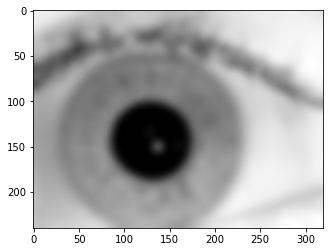

In [25]:
# Smooth with sigma > than eyelashes so that their value gets lower and so, their influence on the segmentation
smooth = cv2.GaussianBlur(img, (21,21), 5)
plt.imshow(smooth, cmap='gray')
im = Image.fromarray(smooth).convert('RGB')
im.save("21.png")

[0.0, 255.0]
[0.0, 239.23396]
[False, True]


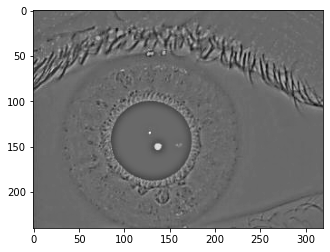

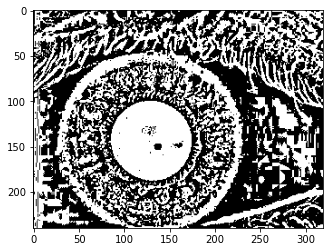

In [26]:
# Get HP image and getting the sign image ot obtain a binary image
print([np.min(img), np.max(img)])
print([np.min(smooth), np.max(smooth)])
diff = (img - smooth) <= 0
print([np.min(diff), np.max(diff)])
plt.imshow((img-smooth), cmap='gray')
plt.show()
plt.imshow(diff, cmap = 'gray')
plt.show()

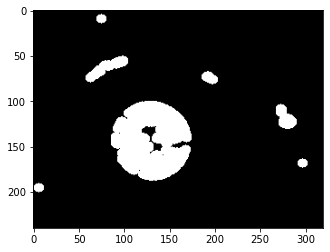

In [27]:
# Opening to remove small elements
op_size = 11
opening = cv2.morphologyEx(np.float32(diff), cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(op_size,op_size)))
#opening = cv2.erode(np.float32(diff),cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(op_size,op_size)),iterations = 1)
#opening = cv2.dilate(opening, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(op_size+2,op_size+2)),iterations = 1)
plt.imshow(opening, cmap='gray')

In [28]:
# Get components 
ret,binary = cv2.threshold(np.uint8(opening),0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
contours, hierarchy= cv2.findContours(binary.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

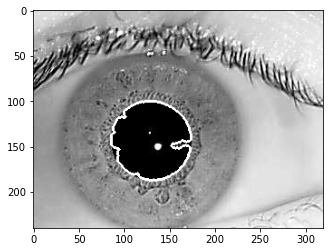

In [29]:
# Get good contour in a 2 step process. 1st area criterion and 2nd getting the more circular one
candidate_contours = []
ecc_vect = []
circ_vect = []
for i, c in enumerate(contours):
    ar = cv2.contourArea(c)
    if ar > 700:
        (center,axes,orientation) = cv2.fitEllipse(c)
        majoraxis_length = max(axes)
        minoraxis_length = min(axes)
        ecc_vect.append(np.sqrt(1-(minoraxis_length/majoraxis_length)**2))
        candidate_contours.append(c)
pupil_cont = candidate_contours[np.argmin(ecc_vect)]
cv2.drawContours(img, pupil_cont, -1, (255,0,0), 2);
plt.imshow(img, cmap='gray')

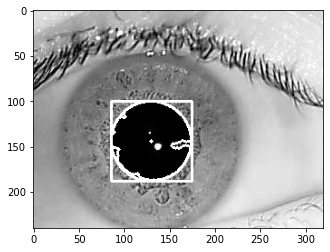

In [30]:
# Get coordinates of the bounding box of the pupil and get the center in a 2 step process
# to avoid wrong center estimation when the pupil es partially covered by the eyelid
x,y,w,h = cv2.boundingRect(pupil_cont)
r_pupil = int(w/2)
cx = int(x + w/2)
cy = (y+h) - r_pupil
cv2.rectangle(img, (cx,cy), (cx,cy), (255,0,0), 3)
#v2.rectangle(img, (x,y), (x+w,y+h), (255,0,0), 2)
cv2.circle(img, (cx, cy), r_pupil, (255, 0, 0), 2)
plt.imshow(img, cmap='gray')

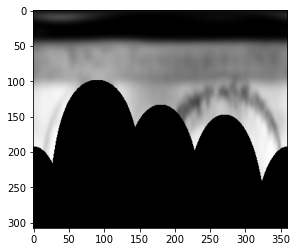

In [32]:
# Moving to polar C.S.
polar_thres, ptSettings = polarTransform.convertToPolarImage(smooth, center = (cx, cy),initialRadius=None, finalRadius=7*r_pupil, radiusSize=7*r_pupil, angleSize=360)
polar_thres = (np.transpose(polar_thres))
plt.imshow(polar_thres, cmap='gray')

Text(0.5, 1.0, 'Correction vector')

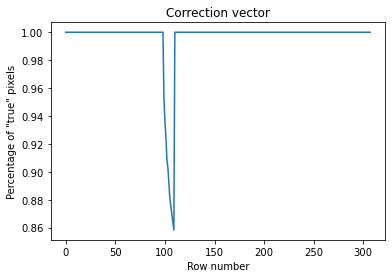

In [34]:
# Create a mask of the artificial 0s created by the polar system conversion
mask = ((polar_thres)!=0.0)

# Count how many 0s have been created row-wise 
notnan = np.sum(mask, axis=1)
unique = np.unique(notnan)
if len(unique==1):
    notnan = notnan/np.max(notnan)
else:
    notnan = (notnan-np.min(notnan))/(np.max(notnan)-np.min(notnan))
# If the newly added 0s are more than 15%, then treat them as if there were no 0s
notnan[notnan<0.85]=1.0

plt.plot((notnan))
plt.xlabel('Row number')
plt.ylabel('Percentage of "true" pixels')
plt.title('Correction vector')

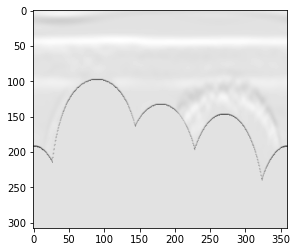

In [35]:
# compute the median of the single channel pixel intensities
sobely = cv2.Sobel(polar_thres,cv2.CV_32F,0,1,ksize=5)
sobely = sobely*mask

plt.imshow(sobely, cmap='gray')


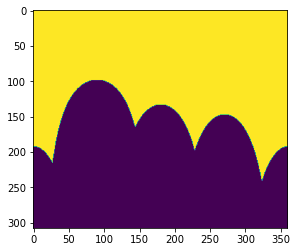

In [36]:
plt.imshow(mask)

[44, 102]


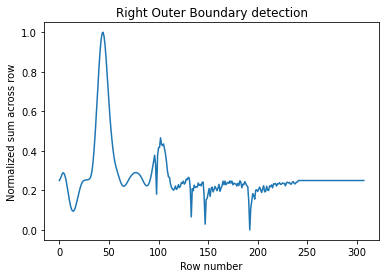

In [37]:
# Multiply the derivative image by the mask to prevent derivatives in the newly added region after polar conversion to affect the sum
sobely = sobely*mask

# Sum the derivative image row-wise
cum_sum = np.sum(sobely,axis=1)

# Normalize the sum by the "true" pixels
# This is the reason why, if the "false" pixels are more than 25%, ignore them
# If not, the maximum of this sum, will always be the rows with high content of "false" pixels
cum_sum = (cum_sum-np.min(cum_sum))/(np.max(cum_sum)-np.min(cum_sum))
cum_sum_corr = cum_sum/notnan

plt.plot(cum_sum_corr)
#plt.plot(cum_sum_corr)
#plt.legend(['Original', 'Corrected'])
plt.xlabel('Row number')
plt.ylabel('Normalized sum across row')
plt.title('Right Outer Boundary detection')


# Search for the second maximum assuming the outer boundary will not be at a radial distance less than 60% of the pupil radius
margin = int(0.8*r_pupil)
r_out_bound = np.argmax(cum_sum_corr[r_pupil+margin:]) + r_pupil+margin
print([r_pupil, r_out_bound])

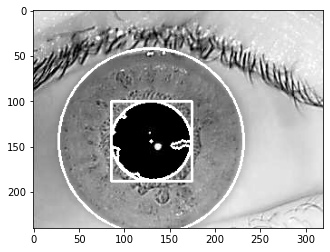

In [39]:
# Plot outer boundary
cv2.circle(img, (cx, cy), r_pupil, (255, 0, 0), 2)
cv2.circle(img, (cx, cy), r_out_bound, (255, 0, 0), 2)
plt.imshow(img, cmap='gray')

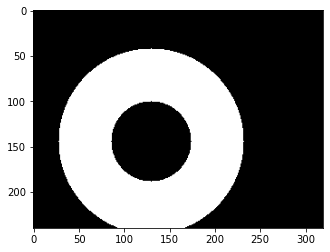

In [41]:
# Mask creation
shape = (240,320)
im1 = np.zeros(shape, np.uint8)
im2 = np.zeros(shape, np.uint8)
cv2.circle(im1, (cx, cy), r_pupil, (255,255,255),-1)
cv2.circle(im2, (cx, cy), r_out_bound, (255,255,255),-1)
im = (im2==255.0) & (im1 == 0.0)
plt.imshow(im, cmap='gray')